### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
379,PSID195,0,32,4,0,0,1,1,0.0000,1378.54800,0.000
68,NSW69,1,45,5,1,0,1,1,0.0000,0.00000,8546.715
415,PSID231,0,18,11,1,0,0,1,587.7800,841.45160,7933.914
37,NSW38,1,23,12,1,0,1,0,0.0000,0.00000,5911.551
108,NSW109,1,30,11,1,0,0,1,0.0000,0.00000,0.000
303,PSID119,0,42,7,0,0,1,1,4324.1020,3457.11300,9856.436
53,NSW54,1,25,12,1,0,0,0,0.0000,0.00000,2348.973
111,NSW112,1,17,9,0,1,0,1,445.1704,74.34345,6210.670
204,PSID20,0,35,9,0,0,1,1,11475.4300,9397.40300,11087.380
430,PSID246,0,41,7,0,0,1,1,19573.0800,565.74190,0.000


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

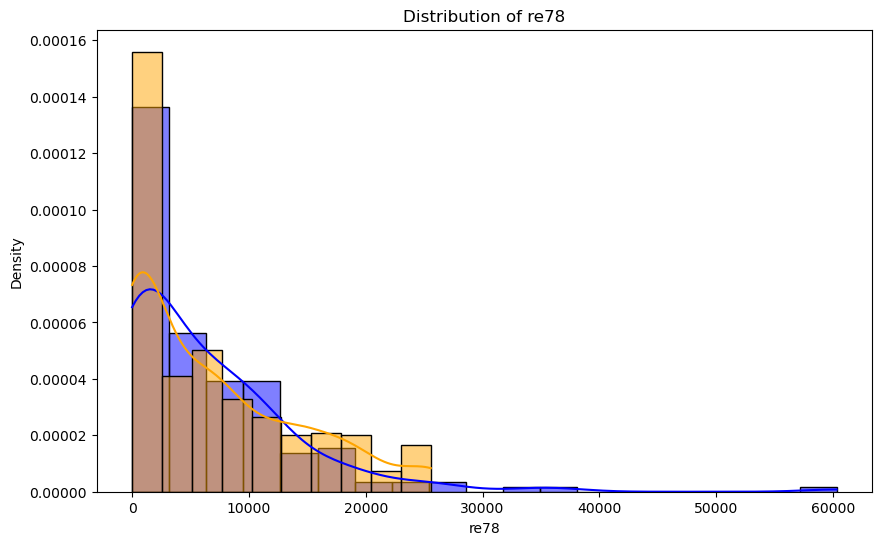

Treated group
Mean: 6349.143530270271
Median: 4232.309

Control group
Mean: 6984.169742307692
Median: 4975.505


' \nTreated group\nMean: 6349.143530270271\nMedian: 4232.309\n\nControl group\nMean: 6984.169742307692\nMedian: 4975.505\n'

In [9]:
''' Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?'''

# Split the data into treated and control
treated = df[df.treat == 1]
control = df[df.treat == 0]

# Plot the distribution of the outcome variable
plt.figure(figsize=(10, 6))
sns.histplot(treated.re78, kde=True, stat='density', color='blue', label='treated')
sns.histplot(control.re78, kde=True, stat='density', color='orange', label='control')

plt.title('Distribution of re78')
plt.show()

# Print the mean and median of the outcome variable for the two groups
print('Treated group')
print('Mean:', treated.re78.mean())
print('Median:', treated.re78.median())
print()
print('Control group')
print('Mean:', control.re78.mean())
print('Median:', control.re78.median())

''' 
Treated group
Mean: 6349.143530270271
Median: 4232.309

Control group
Mean: 6984.169742307692
Median: 4975.505
'''

# The naive researcher might conclude that the control group has a higher mean and median value of the outcome variable `re78` compared to the treated group.


## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

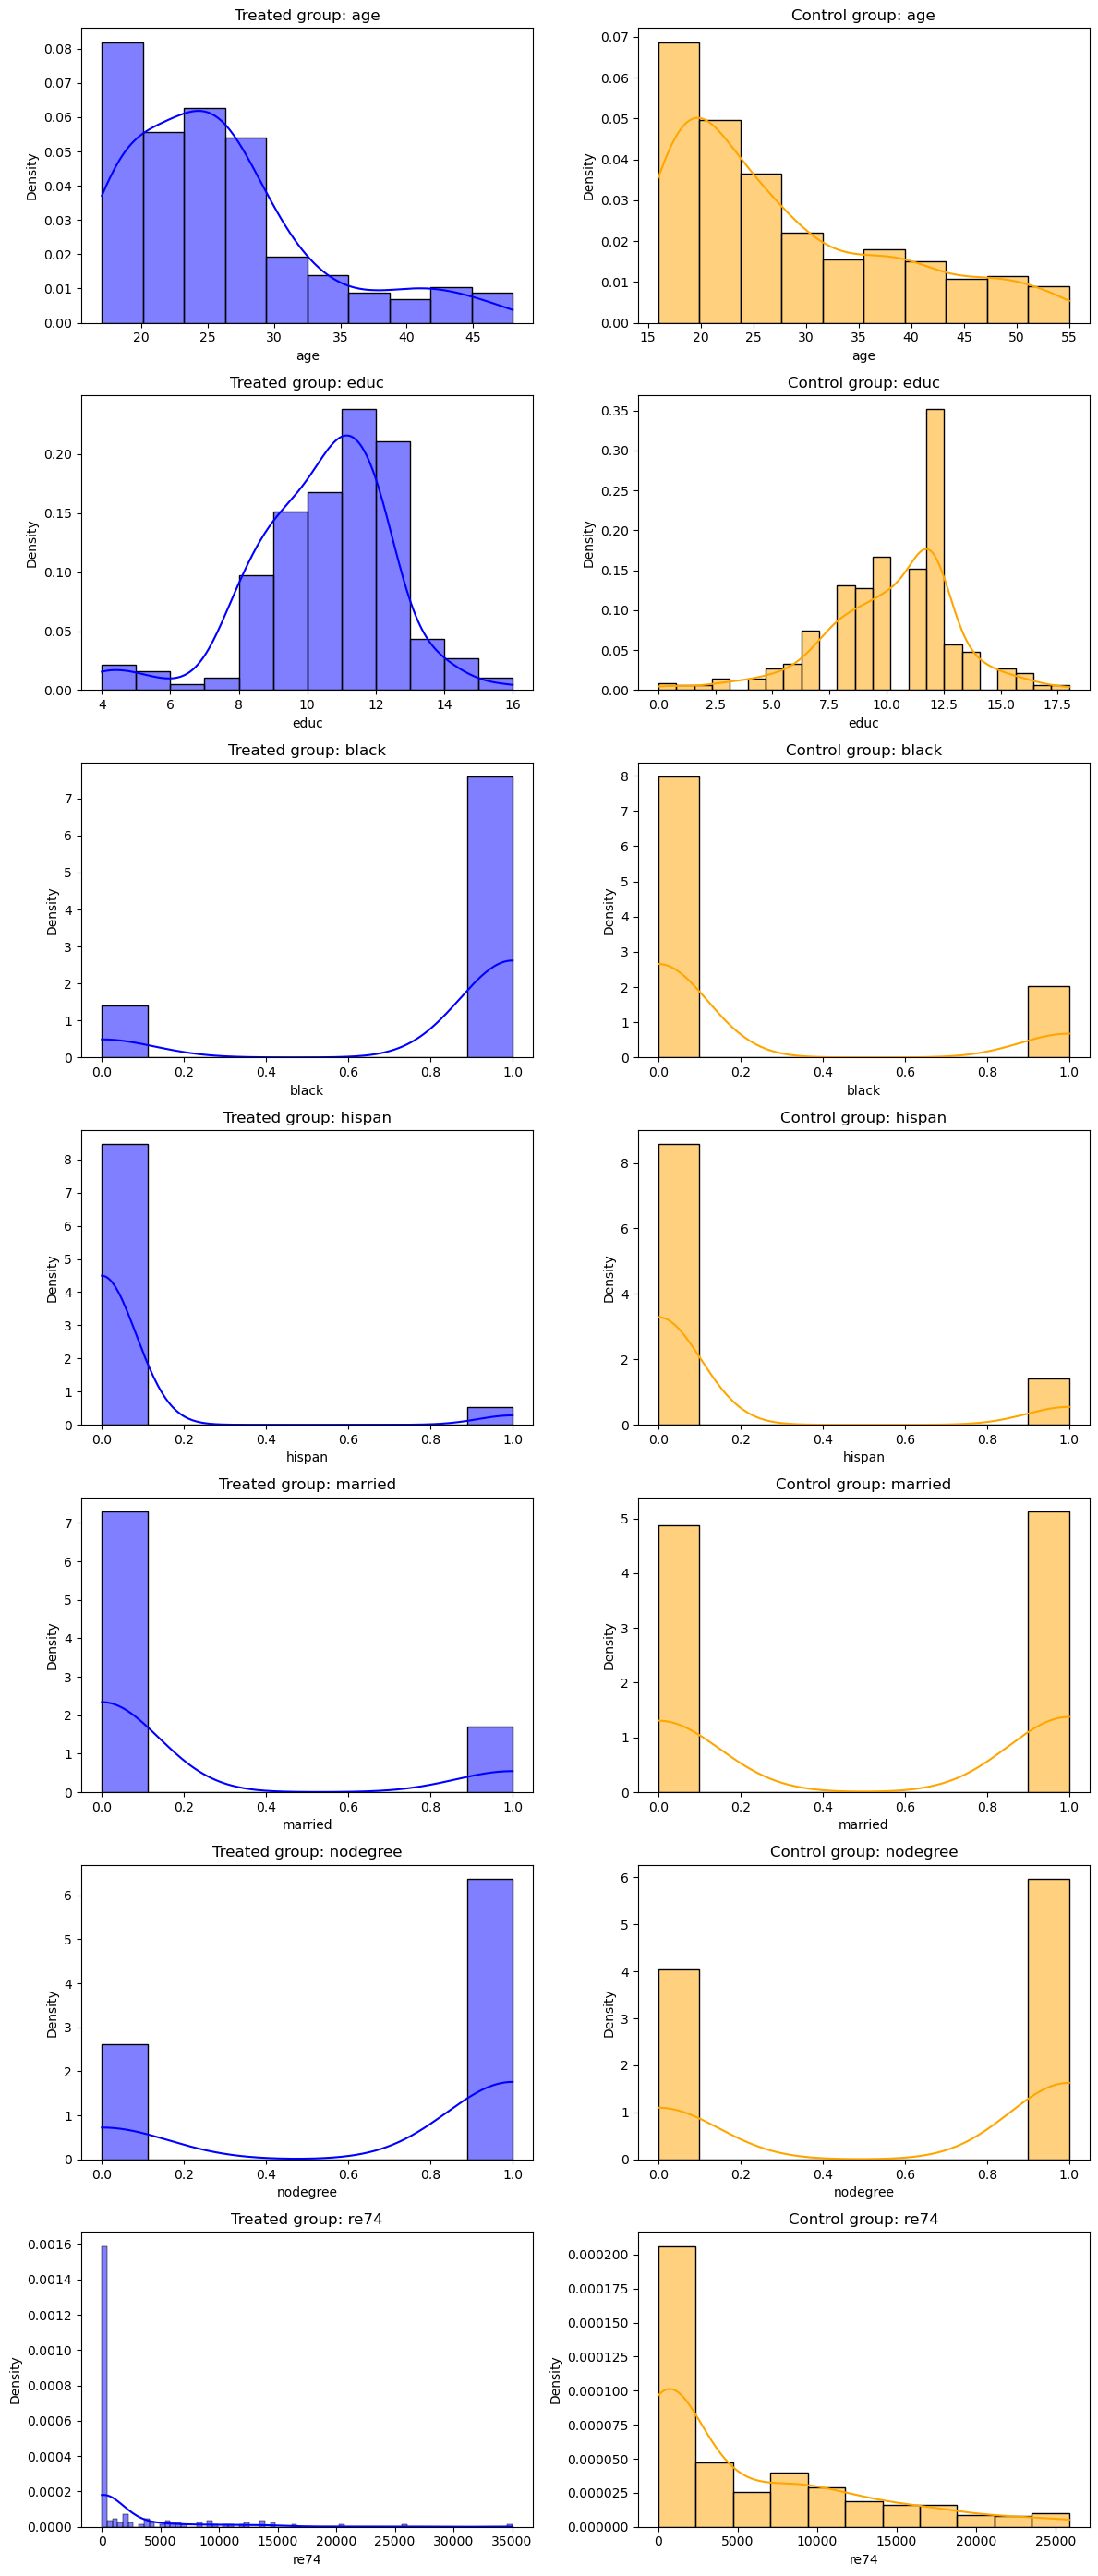

In [12]:
''' You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis. '''

# Plot the distribution of each feature for the two groups
features = df.columns.drop(['treat', 're78', 'id', 're75'])
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(12, 4 * n_features))

for i, feature in enumerate(features):
    sns.histplot(treated[feature], kde=True, stat='density', color='blue', ax=axes[i, 0])
    sns.histplot(control[feature], kde=True, stat='density', color='orange', ax=axes[i, 1])
    axes[i, 0].set_title(f'Treated group: {feature}')
    axes[i, 1].set_title(f'Control group: {feature}')

plt.tight_layout()
plt.show()



In [ ]:
'''
We notice a high propensity difference between the treated and control groups for the following features:
- age
- married
- black
- hispan
'''

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [18]:
''' Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).) '''

import statsmodels.formula.api as smf

# standardize the features age, educ, re74, re75
df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['educ'] = (df['educ'] - df['educ'].mean()) / df['educ'].std()
df['re74'] = (df['re74'] - df['re74'].mean()) / df['re74'].std()
df['re75'] = (df['re75'] - df['re75'].mean()) / df['re75'].std()


# Fit the logistic regression model
logit_model = smf.ols('treat ~ age + educ + C(black) + C(hispan) + C(married) + C(nodegree) + re74 + re75', data=df).fit()

df['propensity_score'] = logit_model.predict()

print(logit_model.summary())



                            OLS Regression Results                            
Dep. Variable:                  treat   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     47.98
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           8.01e-60
Time:                        19:00:35   Log-Likelihood:                -242.04
No. Observations:                 614   AIC:                             502.1
Df Residuals:                     605   BIC:                             541.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0585      0.039  

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

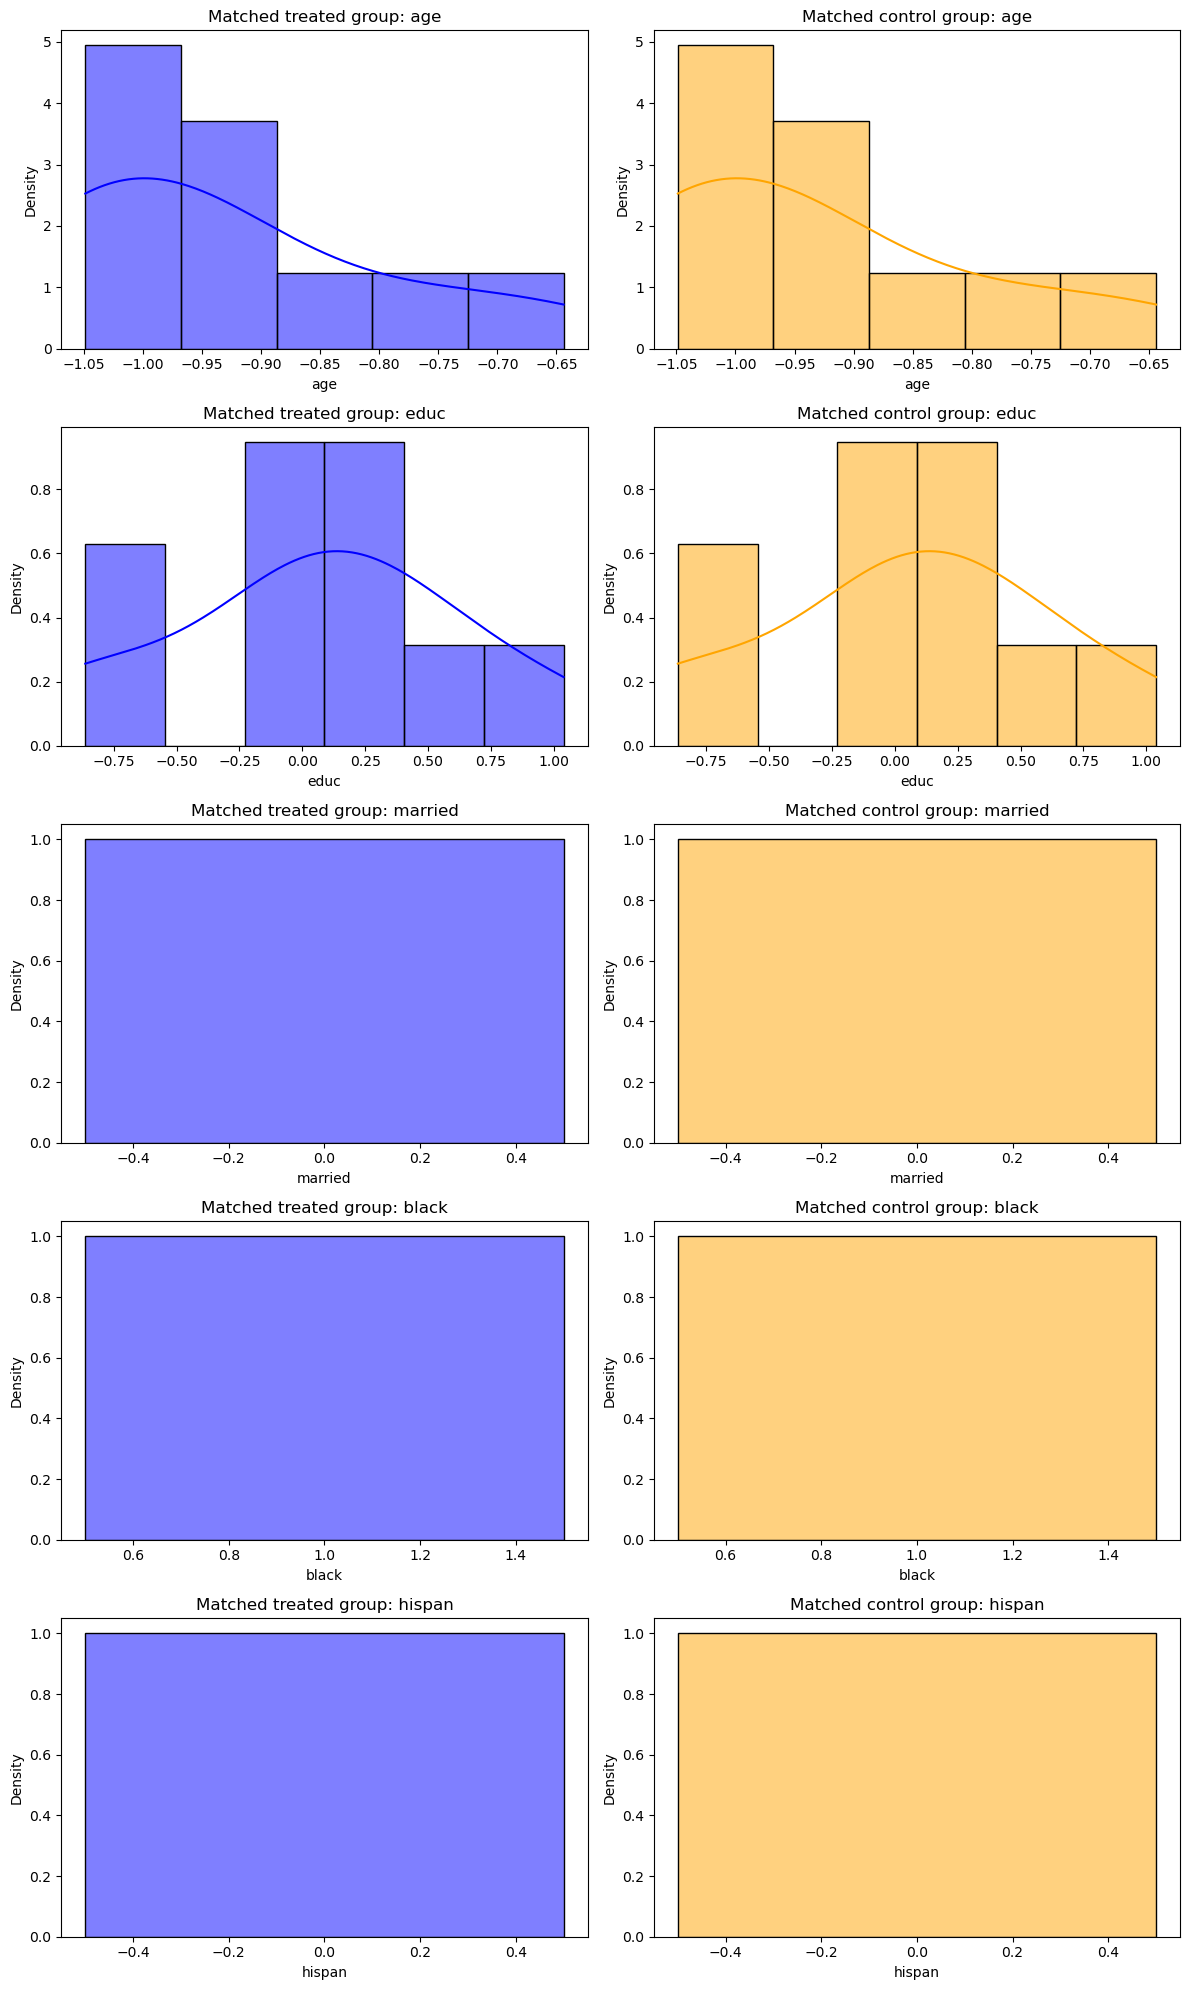

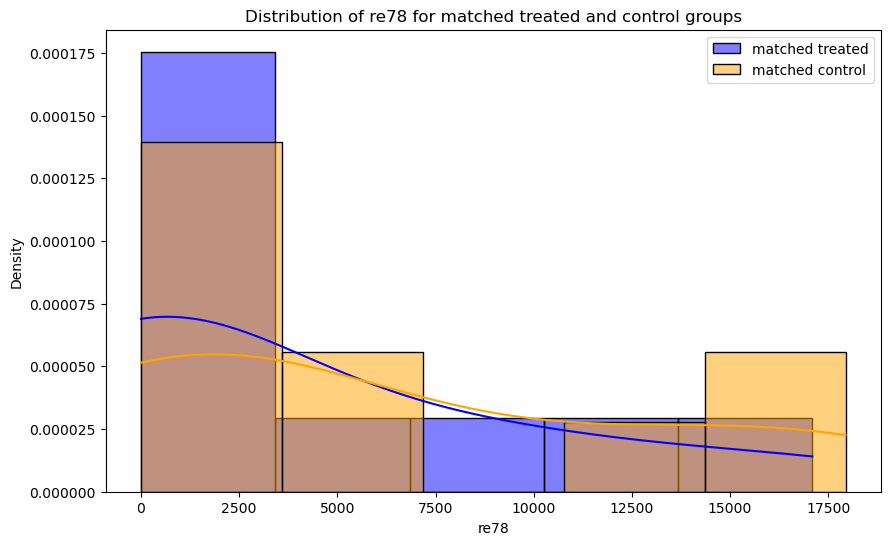

Matched treated group
Mean: 4053.0542
Median: 0.0

Matched control group
Mean: 6218.8651
Median: 3400.9880000000003


In [22]:
# Create a graph with all possible pairs of treated and control subjects
G = nx.Graph()

treated = df[df.treat == 1]
control = df[df.treat == 0]

# Add weighted edges based on similarity (negative absolute difference in propensity scores)
for i, row_treated in treated.iterrows():
    for j, row_control in control.iterrows():
        similarity = -abs(row_treated['propensity_score'] - row_control['propensity_score'])
        G.add_weighted_edges_from([(i, j, similarity)])

# Find the optimal matching
matching = nx.max_weight_matching(G)

# Separate matched treated and control indices
matched_treated_indices = []
matched_control_indices = []

for treated_idx, control_idx in matching:
    # Separate the indices based on whether treated or control comes first in the pair
    if treated_idx in treated.index:
        matched_treated_indices.append(treated_idx)
        matched_control_indices.append(control_idx)
    else:
        matched_treated_indices.append(control_idx)
        matched_control_indices.append(treated_idx)

# Get the matched data points
matched_treated = treated.loc[matched_treated_indices]
matched_control = control.loc[matched_control_indices]

# Define your features for comparison
features = ['age', 'educ', 'married', 'black', 'hispan']  # Replace with your actual feature names
n_features = len(features)

# Plot the distribution of each feature for the matched treated and control groups
fig, axes = plt.subplots(n_features, 2, figsize=(12, 4 * n_features))

for i, feature in enumerate(features):
    sns.histplot(matched_treated[feature], kde=True, stat='density', color='blue', ax=axes[i, 0])
    sns.histplot(matched_control[feature], kde=True, stat='density', color='orange', ax=axes[i, 1])
    axes[i, 0].set_title(f'Matched treated group: {feature}')
    axes[i, 1].set_title(f'Matched control group: {feature}')

plt.tight_layout()
plt.show()

# Plot the distribution of the outcome variable for the matched treated and control groups
plt.figure(figsize=(10, 6))
sns.histplot(matched_treated.re78, kde=True, stat='density', color='blue', label='matched treated')
sns.histplot(matched_control.re78, kde=True, stat='density', color='orange', label='matched control')

plt.title('Distribution of re78 for matched treated and control groups')
plt.legend()
plt.show()

# Print the mean and median of the outcome variable for the matched treated and control groups
print('Matched treated group')
print('Mean:', matched_treated.re78.mean())
print('Median:', matched_treated.re78.median())
print()

print('Matched control group')
print('Mean:', matched_control.re78.mean())
print('Median:', matched_control.re78.median())


## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


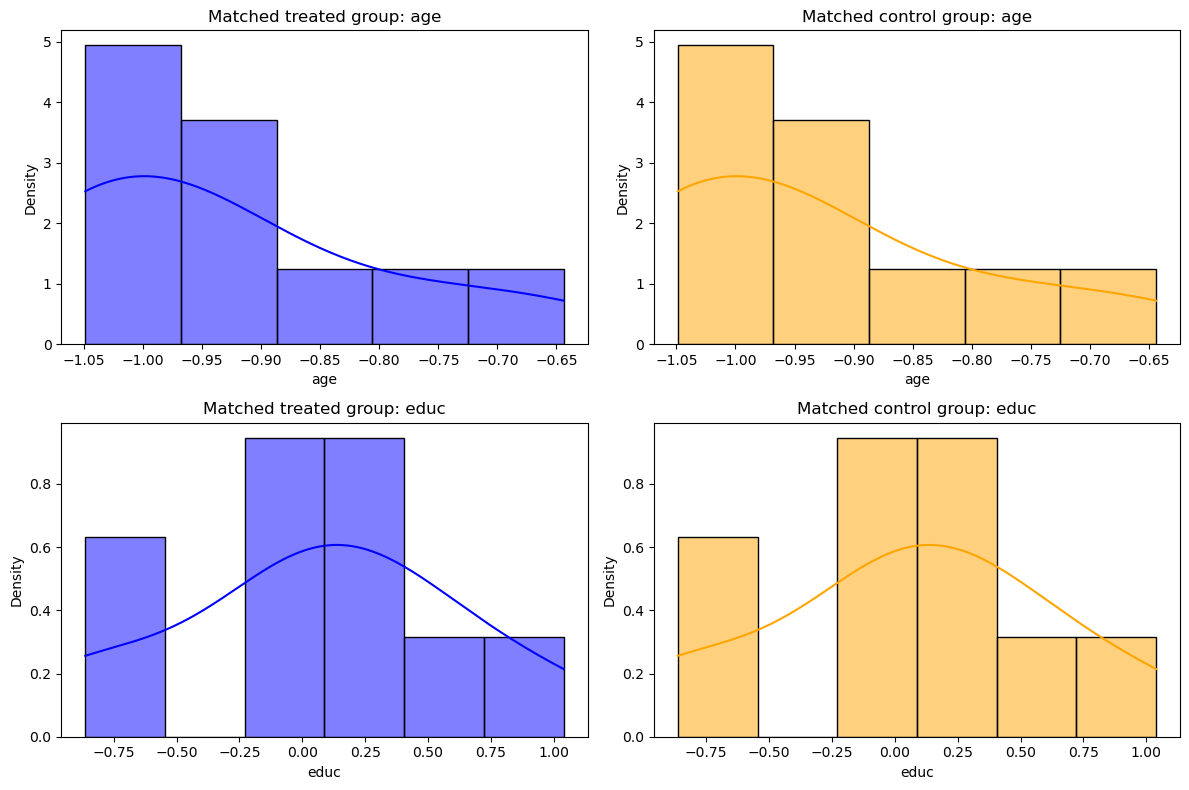

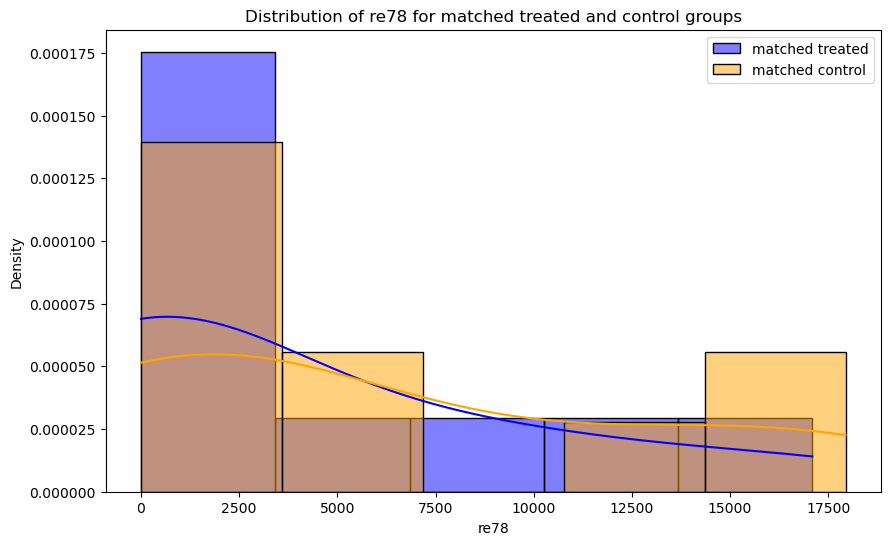

Matched treated group
Mean: 4053.0542
Median: 0.0

Matched control group
Mean: 6218.8651
Median: 3400.9880000000003


In [23]:
# Create a graph with all possible pairs of treated and control subjects
G = nx.Graph()

# Filter treated and control groups
treated = df[df.treat == 1]
control = df[df.treat == 0]

# Define the problematic features for exact matching
exact_match_features = ['married', 'black', 'hispan']  # Ensure both groups have the same value for these features

# Add edges between treated and control subjects only if they match on problematic features
for i, row_treated in treated.iterrows():
    for j, row_control in control.iterrows():
        # Check if the problematic features match exactly
        if all(row_treated[feature] == row_control[feature] for feature in exact_match_features):
            # Calculate similarity based on propensity score difference
            similarity = -abs(row_treated['propensity_score'] - row_control['propensity_score'])
            # Add an edge to the graph for this potential match
            G.add_weighted_edges_from([(i, j, similarity)])

# Find the optimal matching based on maximum similarity (minimum absolute difference in propensity scores)
matching = nx.max_weight_matching(G)

# Separate matched treated and control indices
matched_treated_indices = []
matched_control_indices = []

for treated_idx, control_idx in matching:
    # Separate the indices based on whether treated or control comes first in the pair
    if treated_idx in treated.index:
        matched_treated_indices.append(treated_idx)
        matched_control_indices.append(control_idx)
    else:
        matched_treated_indices.append(control_idx)
        matched_control_indices.append(treated_idx)

# Get the matched data points
matched_treated = treated.loc[matched_treated_indices]
matched_control = control.loc[matched_control_indices]

# Define your features for comparison
features = ['age', 'educ']  # Replace with your actual feature names
n_features = len(features)

# Plot the distribution of each feature for the matched treated and control groups
fig, axes = plt.subplots(n_features, 2, figsize=(12, 4 * n_features))

for i, feature in enumerate(features):
    sns.histplot(matched_treated[feature], kde=True, stat='density', color='blue', ax=axes[i, 0])
    sns.histplot(matched_control[feature], kde=True, stat='density', color='orange', ax=axes[i, 1])
    axes[i, 0].set_title(f'Matched treated group: {feature}')
    axes[i, 1].set_title(f'Matched control group: {feature}')

plt.tight_layout()
plt.show()

# Plot the distribution of the outcome variable for the matched treated and control groups
plt.figure(figsize=(10, 6))
sns.histplot(matched_treated.re78, kde=True, stat='density', color='blue', label='matched treated')
sns.histplot(matched_control.re78, kde=True, stat='density', color='orange', label='matched control')

plt.title('Distribution of re78 for matched treated and control groups')
plt.legend()
plt.show()

# Print the mean and median of the outcome variable for the matched treated and control groups
print('Matched treated group')
print('Mean:', matched_treated.re78.mean())
print('Median:', matched_treated.re78.median())
print()

print('Matched control group')
print('Mean:', matched_control.re78.mean())
print('Median:', matched_control.re78.median())


## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

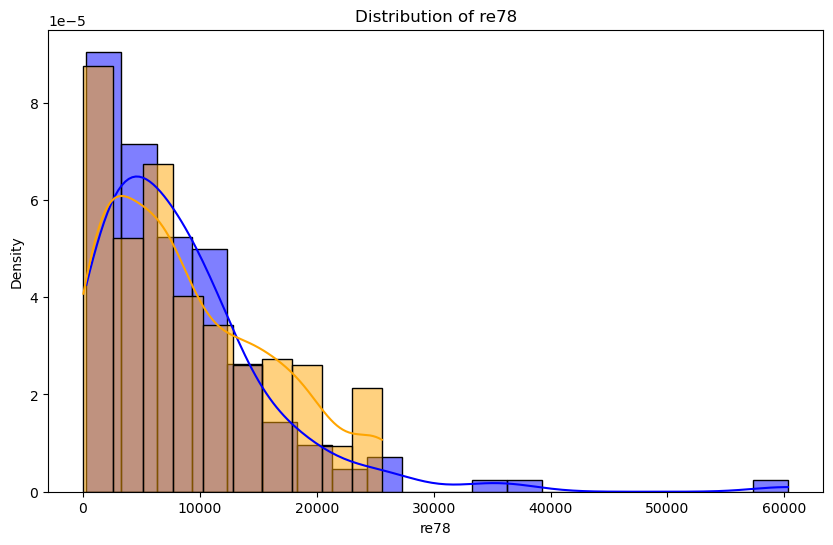

Treated group
count      140.000000
mean      8389.939665
std       8042.944693
min        289.789900
25%       3167.353750
50%       6504.144500
75%      11017.730000
max      60307.930000
Name: re78, dtype: float64
Control group
count      331.000000
mean      9051.990391
std       7087.340468
min         31.032260
25%       2978.358000
50%       7310.313000
75%      14131.500000
max      25564.670000
Name: re78, dtype: float64


In [25]:
# remove ones with re78 == 0 from treated and control and describe both 
treated = treated[treated.re78 != 0]
control = control[control.re78 != 0]

# Plot the distribution of the outcome variable for the two groups
plt.figure(figsize=(10, 6))
sns.histplot(treated.re78, kde=True, stat='density', color='blue', label='treated')
sns.histplot(control.re78, kde=True, stat='density', color='orange', label='control')

plt.title('Distribution of re78')
plt.show()

# Print the mean and median of the outcome variable for the two groups
print('Treated group')
print(treated.re78.describe())

print('Control group')
print(control.re78.describe())